In [22]:
from zipfile import ZipFile 
  
# loading the temp.zip and creating a zip object 
with ZipFile("fashion/images.zip", 'r') as zObject: 
  
    # Extracting all the members of the zip  
    # into a specific location. 
    zObject.extractall( 
        path="fashion") 

# **Import Libraries**

In [3]:
import os
import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp

from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import corpus_bleu
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator
import warnings
warnings.filterwarnings("ignore")

# **GPU Testing**

In [4]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4090


# **Defining Hyperparameters**

In [5]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "google/vit-base-patch16-224-in21k"
    DECODER = "distilgpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 5
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [6]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.2.crossattention.c_attn.bias', 'transformer.h.2.crossattention.c_attn.weight', 'transformer.h.2.crossattention.c_proj.bias', 'transformer.h.2.cr

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# **Tokenizer**

In [7]:
# image feature extractor
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(config.ENCODER)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [8]:
tokenizer.pad_token = tokenizer.eos_token

model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id

model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [9]:
model_name = 'vit-gpt'

model_dir = f'./models_gpt/{model_name}'
model_output_dir = f'{model_dir}/image-captioning-output'
output_dir = f'{model_dir}/vit-gpt-model'

In [10]:
model.save_pretrained(output_dir)
feature_extractor.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warning will be

('./models_gpt/vit-gpt/vit-gpt-model/tokenizer_config.json',
 './models_gpt/vit-gpt/vit-gpt-model/special_tokens_map.json',
 './models_gpt/vit-gpt/vit-gpt-model/vocab.json',
 './models_gpt/vit-gpt/vit-gpt-model/merges.txt',
 './models_gpt/vit-gpt/vit-gpt-model/added_tokens.json',
 './models_gpt/vit-gpt/vit-gpt-model/tokenizer.json')

# **Defining Evalution Matrix**

In [2]:
pip install evaluate rouge_score

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk==3.8.1

Note: you may need to restart the kernel to use updated packages.


In [11]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [12]:
import numpy as np
import evaluate
ignore_pad_token_for_loss = True

metric = evaluate.load("rouge")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

import nltk.translate.bleu_score as bleu

# Thêm hàm tính BLEU scores
def compute_bleu(preds, labels, n):
    bleu_scores = []
    for pred, label in zip(preds, labels):
        pred_tokens = nltk.word_tokenize(pred.lower())
        label_tokens = nltk.word_tokenize(label.lower())
        bleu_score = bleu.sentence_bleu([label_tokens], pred_tokens, weights=[1.0/n]*n)
        bleu_scores.append(bleu_score)
    return bleu_scores


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    # Compute BLEU@1 and BLEU@2
    bleu1_scores = compute_bleu(decoded_preds, decoded_labels, 1)
    bleu2_scores = compute_bleu(decoded_preds, decoded_labels, 2)
    bleu3_scores = compute_bleu(decoded_preds, decoded_labels, 3)
    bleu4_scores = compute_bleu(decoded_preds, decoded_labels, 4)

    # Compute ROUGE scores
    rouge_scores = metric.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  use_stemmer=True)
    rouge_scores = {k: round(v * 100, 4) for k, v in rouge_scores.items()}
    
    meteor_scores = meteor.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  )

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    gen_len_mean = np.mean(prediction_lens)

    result = {
        "bleu_1": round(np.mean(bleu1_scores) * 100, 4),
        "bleu_2": round(np.mean(bleu2_scores) * 100, 4),
        "bleu_3": round(np.mean(bleu3_scores) * 100, 4),
        "bleu_4": round(np.mean(bleu4_scores) * 100, 4),
        **rouge_scores,
        "meteor": round(meteor_scores['meteor']*100, 4),
        "gen_len": gen_len_mean
    }
    return result


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# **Normalization Of Image**

In [13]:
from torchvision import io, transforms
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)

# **Loading Dataset**

In [14]:
import pandas as pd
df = pd.read_csv('fashion/output.csv')

In [15]:
df = df.iloc[:20000]

In [16]:
from sklearn.model_selection import train_test_split
dtrain , dval = train_test_split(df , test_size = 0.2)

# **Load Image For Training**

In [17]:
from PIL import Image
import torch


class ImageCapatioingDataset(torch.utils.data.Dataset):
    def __init__(self, df,root_dir,max_target_length, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.max_target_length = max_target_length

    def __getitem__(self, idx):
        image = self.df.image.iloc[idx]
        image_path = os.path.join(self.root_dir , image)
        caption = self.df.caption.iloc[idx]
        model_inputs = dict()
        model_inputs['labels'] = self.tokenization_fn(caption, self.max_target_length)
        model_inputs['pixel_values'] = self.feature_extraction_fn(image_path)
        return model_inputs

    def __len__(self):
        return len(self.df)
    
    # text preprocessing step
    def tokenization_fn(self, caption, max_target_length):
        labels = tokenizer(caption, 
                          padding="max_length", 
                          max_length=max_target_length,
                          truncation=True).input_ids

        return labels
    
    # image preprocessing step
    def feature_extraction_fn(self, image_path):
        image = Image.open(image_path).convert('RGB')

        encoder_inputs = feature_extractor(images=image, return_tensors="np")

        return encoder_inputs.pixel_values[0]


train_dataset = ImageCapatioingDataset(dtrain, root_dir = "fashion/images/",max_target_length = 64,transform = transforms)
val_dataset = ImageCapatioingDataset(dval, root_dir = "fashion/images/",max_target_length = 64,transform = transforms)

# **Model Initialization**

# **Training**

In [19]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    output_dir=output_dir,
    num_train_epochs = 10,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [20]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Bleu 1,Bleu 2,Bleu 3,Bleu 4,Rouge1,Rouge2,Rougel,Rougelsum,Meteor,Gen Len
1,No log,0.614078,36.318600,22.091200,15.025300,11.050500,40.871000,18.858800,36.188300,36.911100,34.706000,27.257750
2,0.842500,0.493255,41.247700,28.536200,21.285800,16.548900,47.162300,26.070800,42.505200,43.276300,41.363800,27.998000
3,0.842500,0.437956,46.333700,34.106100,26.556200,21.108000,52.477100,31.468700,47.435900,48.404500,47.762800,28.969750
4,0.470800,0.405237,48.539200,36.683200,29.201000,23.699200,55.740900,34.821200,50.212900,51.236800,49.817600,27.504500
5,0.470800,0.383803,49.671100,37.738000,30.184700,24.622000,56.374900,35.553400,50.916600,51.998300,51.124400,28.482500
6,0.383300,0.369711,51.145100,39.515800,31.864500,26.365200,57.907900,37.502200,52.566600,53.586600,52.592200,28.513500
7,0.383300,0.359629,52.450700,41.058800,33.460000,27.843500,59.162200,39.169200,53.938400,54.991700,53.917600,28.674500
8,0.331300,0.354771,53.474900,42.117000,34.638300,29.126200,60.121800,40.192400,54.921600,55.985900,55.027400,28.706000
9,0.331300,0.351889,54.196600,43.109100,35.610900,30.018300,61.055400,41.301800,55.822200,56.823300,55.682600,28.311500
10,0.301600,0.351296,54.553100,43.441300,35.909800,30.338500,61.234500,41.570000,56.056500,57.063000,56.239200,28.810250


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingfac

TrainOutput(global_step=2500, training_loss=0.4658971618652344, metrics={'train_runtime': 9586.5081, 'train_samples_per_second': 16.69, 'train_steps_per_second': 0.261, 'total_flos': 2.06791426179072e+19, 'train_loss': 0.4658971618652344, 'epoch': 10.0})

In [21]:
trainer.save_model(model_output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}


In [22]:
tokenizer.save_pretrained(model_output_dir)

('./models_gpt/vit-gpt/image-captioning-output/tokenizer_config.json',
 './models_gpt/vit-gpt/image-captioning-output/special_tokens_map.json',
 './models_gpt/vit-gpt/image-captioning-output/vocab.json',
 './models_gpt/vit-gpt/image-captioning-output/merges.txt',
 './models_gpt/vit-gpt/image-captioning-output/added_tokens.json',
 './models_gpt/vit-gpt/image-captioning-output/tokenizer.json')

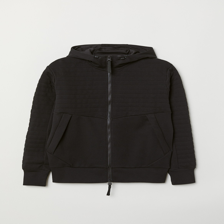

**Actual Caption**: Jacket in sturdy jersey with quilted sections at the top and on the sleeves. Mesh-lined hood with an elasticated drawstring, zip down the front, side pockets with a concealed zip and ribbing at the cuffs and hem. Unlined.
**Predicted Caption**: Jacket in sturdy jersey with a zip down the front, side pockets and ribbing at the cuffs and hem. Lined.


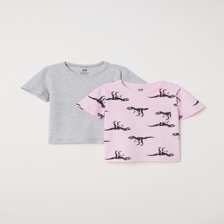

**Actual Caption**: T-shirts in soft, organic cotton jersey.
**Predicted Caption**: Long-sleeved tops in soft organic cotton jersey.


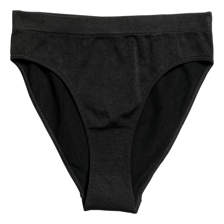

**Actual Caption**: Bikini briefs in soft stretch fabric with a mid waist, lined gusset, wide sides and medium coverage at the back.
**Predicted Caption**: Fully lined bikini bottoms with a low waist and medium coverage at the back.


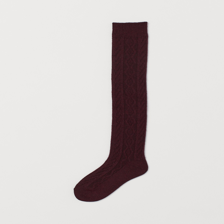

**Actual Caption**: Over-the-knee socks in a soft, fine knit containing some wool.
**Predicted Caption**: Fine-knit socks in a soft cotton blend with wide elastication at the top.


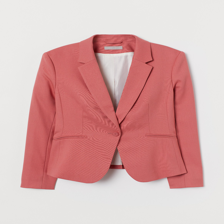

**Actual Caption**: Fitted jacket in woven fabric with notch lapels, jetted front pockets, a decorative button at the cuffs and a single back vent. Lined.
**Predicted Caption**: Short jacket in woven fabric with notch lapels, jetted front pockets, a decorative button at the cuffs and a single back vent. Lined. Skinny fit – a slightly shorter style that shapes in at the chest and tapers at the hem. Slightly longer at the back.


In [23]:
import os
import random
import pandas as pd
from PIL import Image
from torchvision.transforms import functional as F
import torch
from transformers import ViTImageProcessor

model = VisionEncoderDecoderModel.from_pretrained(model_output_dir)
feature_extractor = ViTImageProcessor.from_pretrained(model_output_dir)
tokenizer = AutoTokenizer.from_pretrained(model_output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 64
num_beams = 4
gen_kwargs = {
    "max_length": max_length,
    "num_beams": num_beams,
    # "num_return_sequences": 3,
}

def load_random_image_and_caption(image_dir, captions_file):
    
    captions_df = pd.read_csv(captions_file)
    captions_df = captions_df.iloc[:20000]

    if 'image' not in captions_df.columns:
        print("Column 'image' not found in the CSV file.")
        return None, None


    random_row = captions_df.sample(n=1)
    random_image_name = random_row['image'].values[0]

    image_path = os.path.join(image_dir, random_image_name)

    if not os.path.isfile(image_path):
        print(f"Image file not found: {image_path}")
        return None, None

    if 'caption' in captions_df.columns:
        actual_caption = random_row['caption'].values[0]
    else:
        actual_caption = None

    return image_path, actual_caption

def predict_step(image_dir, captions_file):

    image_path, actual_caption = load_random_image_and_caption(image_dir, captions_file)

    if image_path is None or actual_caption is None:
        return

    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")
    i_image = i_image.resize((224, 224))

    display(i_image)

    image_tensor = F.to_tensor(i_image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    output_ids = model.generate(image_tensor, **gen_kwargs)

    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    print(f"**Actual Caption**: {actual_caption}")
    print(f"**Predicted Caption**: {pred}")

image_directory = 'fashion/images'
captions_csv_file = 'fashion/output.csv'
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)